In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random


C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    #random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [89]:
dataset = "../../Pics/BigOne_5"
#dataset = "../../Pics/RaceTrack/NewTrack_noFE_Cleaned_Mirrored_5"

In [90]:
# load images from both train and test groups
directory = '../../'+dataset+'/Train'
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 6822


In [91]:
#Normalise images
images = np.array(images)
images /= 255

In [92]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

(array([1, 0], dtype=uint8),
 array([1, 0, 0, 0, 0], dtype=uint8),
 <matplotlib.image.AxesImage at 0x1eb3a7c5550>)

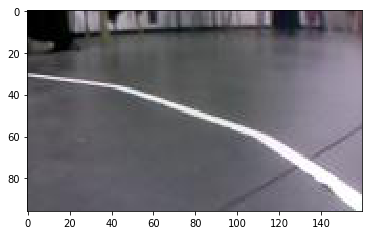

In [93]:
labels_speed[42], labels_dir[42], plt.imshow(images[42])

In [94]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [95]:
#from keras.models import load_model
#model = load_model("model.h5")

In [96]:
K.clear_session()
############################################################# Multitask Model 1

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution2D(36, (5,5), strides=(2,2), activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution2D(48, (5,5), strides=(2,2), activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution2D(64, (3,3), activation='relu')(x)

x = Flatten(name='flattened')(x)

#x = Dense(1164, activation='relu')(x)
#x = Dropout(0.3)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = Dense(10, activation='relu')(x)   
out_speed = Dense(2, activation='softmax')(x)
out_dir = Dense(5, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 78, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 21, 37, 36)   21636       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [97]:
h = model.fit(images, [labels_speed, labels_dir], batch_size=64, epochs=5, verbose=1)

Epoch 1/5
6822/6822 [==============================] - 952s 139ms/step - loss: 2.0296 - dense_4_loss: 0.5145 - dense_5_loss: 1.5151 - dense_4_acc: 0.7835 - dense_5_acc: 0.3490
Epoch 2/5
6822/6822 [==============================] - 965s 141ms/step - loss: 1.4017 - dense_4_loss: 0.3143 - dense_5_loss: 1.0874 - dense_4_acc: 0.8918 - dense_5_acc: 0.5773
Epoch 3/5
4096/6822 [=================>............] - ETA: 6:25 - loss: 1.0140 - dense_4_loss: 0.2288 - dense_5_loss: 0.7851 - dense_4_acc: 0.9292 - dense_5_acc: 0.7236

KeyboardInterrupt: 

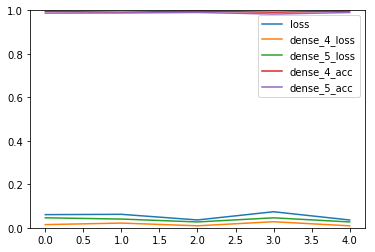

In [78]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [79]:
model.save('model_multi5.h5')

In [51]:
#######################  VALIDATION

In [52]:
#from keras.models import load_model
#model = load_model("../../model_multi_race5.h5")

In [53]:
#print(model.to_json())

In [54]:
directory = '../../'+dataset+'/Val'
images_val, labels_speed_val, labels_dir_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

Loaded Images and labels for validation: 1070


In [55]:
images_val = np.array(images_val)
images_val /= 255

In [80]:
# Get predictions
all_preds = model.predict(images_val)

speed_preds = []
for elem in all_preds[0]:
    speed_preds.append(np.argmax(elem))
    
dir_preds = []
for elem in all_preds[1]:
    dir_preds.append(np.argmax(elem))

In [81]:
res = 0
for i, value in enumerate(speed_preds):
    if value != labels_speed_val[i]:
        res += 1
print("error_rate = " + str(res/i))

error_rate = 0.04677268475210477


In [82]:
res = 0

i_0 = 1
res_0 = 0
res_0_1 = 0
res_0_2 = 0
res_0_3 = 0
res_0_4 = 0

i_1 = 1
res_1 = 0
res_1_1 = 0
res_1_2 = 0
res_1_3 = 0

i_2 = 1
res_2 = 0
res_2_1 = 0
res_2_2 = 0

i_3 = 1
res_3 = 0
res_3_1 = 0
res_3_2 = 0
res_3_3 = 0

i_4 = 1
res_4 = 0
res_4_1 = 0
res_4_2 = 0
res_4_3 = 0
res_4_4 = 0

for value in labels_dir_val:
    if value == 0:
        i_0 += 1
    elif value == 1:
        i_1 += 1
    elif value == 2:
        i_2 += 1
    elif value == 3:
        i_3 += 1
    elif value == 4:
        i_4 += 1

for i, value in enumerate(dir_preds):
    if value != labels_dir_val[i]:
        res += 1
        if labels_dir_val[i] == 0:    
            res_0 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_0_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_0_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_0_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_0_4 += 1
        elif labels_dir_val[i] == 1:
            res_1 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_1_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_1_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_1_3 += 1
        elif labels_dir_val[i] == 2:
            res_2 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_2_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_2_2 += 1
        elif labels_dir_val[i] == 3:
            res_3 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_3_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_3_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_3_3 += 1
        elif labels_dir_val[i] == 4:
            res_4 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_4_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_4_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_4_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_4_4 += 1

        
print("total error = " + str(res/i), "0_error = " + str(res_0/i_0), "1_error = " + str(res_1/i_1), "2_error = " + str(res_2/i_2), "3_error = " + str(res_3/i_3), "4_error = " + str(res_4/i_4), )

total error = 0.04957904583723106 0_error = 0.029239766081871343 1_error = 0.05429864253393665 2_error = 0.044673539518900345 3_error = 0.08144796380090498 4_error = 0.029239766081871343


Text(0.5,1,'Mean Errors by direction')

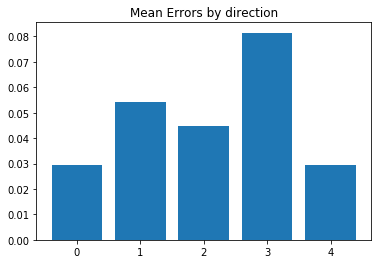

In [83]:
x = ['0','1','2','3','4']
plt.bar(x, height= [res_0/i_0, res_1/i_1, res_2/i_2, res_3/i_3, res_4/i_4])
plt.xticks(x, ['0','1','2','3','4']);
plt.title("Mean Errors by direction")

Text(0.5,1,'0 Errors')

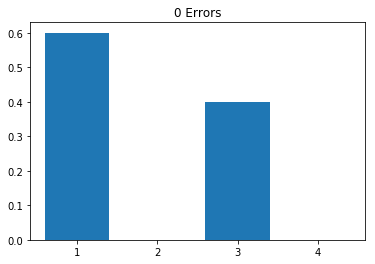

In [84]:
x = ['1','2','3','4']
plt.bar(x, height= [res_0_1/res_0, res_0_2/res_0, res_0_3/res_0, res_0_4/res_0])
plt.xticks(x, ['1','2','3','4']);
plt.title("0 Errors")

Text(0.5,1,'1 Errors')

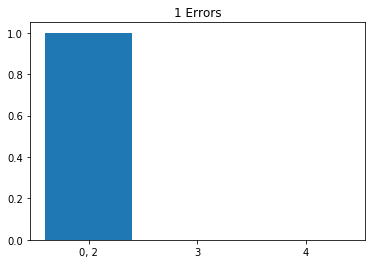

In [85]:
x = ['1','2','3']
plt.bar(x, height= [res_1_1/res_1, res_1_2/res_1, res_1_3/res_1])
plt.xticks(x, ['0, 2','3', '4']);
plt.title("1 Errors")

Text(0.5,1,'2 Errors')

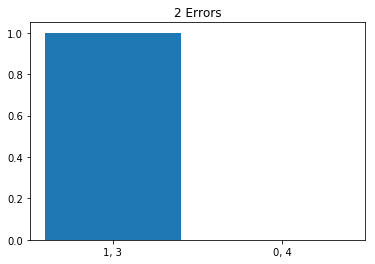

In [86]:
x = ['1','2']
plt.bar(x, height= [res_2_1/res_2, res_2_2/res_2])
plt.xticks(x, ['1, 3','0, 4']);
plt.title("2 Errors")

Text(0.5,1,'3 Errors')

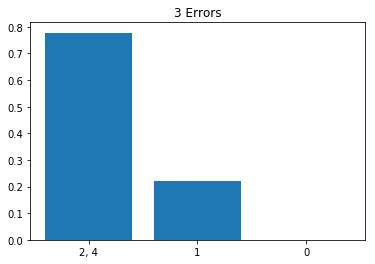

In [87]:
x = ['1','2','3']
plt.bar(x, height= [res_3_1/res_3, res_3_2/res_3, res_3_3/res_3])
plt.xticks(x, ['2, 4','1', '0']);
plt.title("3 Errors")

Text(0.5,1,'4 Errors')

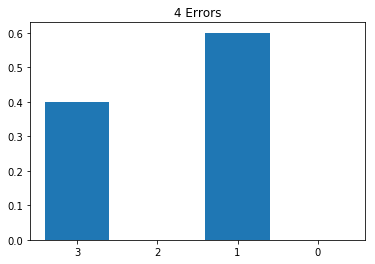

In [88]:
x = ['1','2','3','4']
plt.bar(x, height= [res_4_1/res_4, res_4_2/res_4, res_4_3/res_4, res_4_4/res_4])
plt.xticks(x, ['3','2','1','0']);
plt.title("4 Errors")